In [1]:
import warnings
warnings.filterwarnings('ignore')

# Libraries

## Basic libraries

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

from sklearn.model_selection import LeaveOneOut, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.base import clone

from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, save_stabl_results
from stabl.preprocessing import LowInfoFilter, remove_low_info_samples

%config InlineBackend.figure_formats=['retina']

## Stabl pipelines

In [3]:
from stabl.multi_omic_pipelines import multi_omic_stabl, multi_omic_stabl_cv
from stabl.single_omic_pipelines import single_omic_stabl, single_omic_stabl_cv
from stabl.pipelines_utils import compute_features_table

# Data

## Importing dataset

In [20]:
dataset = pd.read_csv("../Sample Data/Stroke/preprocessed_HT.csv")
dataset.shape


(19320, 7)

In [21]:
# cellpop = 'Bcells*'

# data1 = dataset[(dataset['population']==cellpop) & (dataset['time']=='P1')]
# data2 = dataset[(dataset['population']==cellpop) & (dataset['time']=='P2')]

    
    
# # Rearrangement of the data
# dict_x1 = {}
# dict_x2 = {}
# dict_y = {}
# for sample in data1['sampleID']:
#     dict_x1[sample] = {}
#     dict_x2[sample] = {}
#     for feature in data1['reagent'].unique():
#         mask1 = (data1['sampleID']==sample) & (data1['reagent']==feature)
#         mask2 = (data2['sampleID']==sample) & (data2['reagent']==feature)
#         dict_x1[sample][feature] = float(data1[mask1]['feature'])
#         dict_x2[sample][feature] = float(data2[mask2]['feature'])
#     dict_y[sample] = data1[data1['sampleID']==sample]['group'].iloc[0]

# X1 = pd.DataFrame(dict_x1).T
# X2 = pd.DataFrame(dict_x2).T


In [22]:
#X1

In [23]:
for column in dataset.columns:
    print(f"{column} values : {dataset[column].unique()}")
    print(f"card({column}) : {len(dataset[column].unique())}")
    print()

sampleID values : [1326 1330 1331 1337 1357 1377 1381 1400 1414 1418 1427 1428 1431 1464
 1469 1472 1473 1475 1480 1488]
card(sampleID) : 20

population values : ['Bcells*' 'CCR2nncMC*' 'CCR2pcMC*' 'CD41hiCD61hiPLT*' 'CD4Tcm*' 'CD4Tem*'
 'CD4Tnaive*' 'CD4Trm*' 'CD56brightCD16nNKcells*' 'CD56dimCD16pNKcells*'
 'CD61pCD41pPLT*' 'CD62LnAgedNeutrophils*' 'CD62LpImmatureNeutrophils*'
 'CD8Tcm*' 'CD8Tem*' 'CD8Tnaive*' 'CD8Trm*' 'gdTcells*' 'intMC*' 'mDC*'
 'MDSC*' 'NKT*' 'pDC*' 'Th1mem*' 'Th1naive*' 'Tregmem*' 'Tregnaive*']
card(population) : 27

reagent values : ['CREB' 'STAT5' 'p38' 'STAT1' 'STAT3' 'S6' 'IkB' 'NFkB' 'ERK' 'STAT6'
 'MAPKAPK2' 'Frequency']
card(reagent) : 12

time values : ['P1' 'P3' 'P2']
card(time) : 3

stimulation values : ['Unstim']
card(stimulation) : 1

feature values : [0.16376094 0.01940237 0.         ... 0.71118115 0.21365683 0.02493233]
card(feature) : 15044

group values : ['No' 'Yes']
card(group) : 2



# Test 1 : for Bcells

In [24]:
dataset = dataset[dataset['population']=='Bcells*']
dataset['group'][dataset['group']=='No']=0
dataset['group'][dataset['group']=='Yes']=1
dataset

/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_9735/4151183322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['group'][dataset['group']=='Yes']=1


,sampleID,population,reagent,time,stimulation,feature,group
0,1326,Bcells*,CREB,P1,Unstim,0.163761,0
1,1326,Bcells*,STAT5,P1,Unstim,0.019402,0
2,1326,Bcells*,p38,P1,Unstim,0.000000,0
3,1326,Bcells*,STAT1,P1,Unstim,0.000000,0
4,1326,Bcells*,STAT3,P1,Unstim,0.000000,0
...,...,...,...,...,...,...,...
715,1488,Bcells*,NFkB,P1,Unstim,0.617994,1
716,1488,Bcells*,ERK,P1,Unstim,0.062619,1
717,1488,Bcells*,STAT6,P1,Unstim,0.000000,1
718,1488,Bcells*,MAPKAPK2,P1,Unstim,0.559347,1


# P1

In [25]:
data_path = Path('./Data', 'Test')
os.makedirs(data_path, exist_ok=True)
os.makedirs('./Results', exist_ok=True)

In [26]:
P3_dataset = dataset[dataset['time']=='P3']

## Multivariate Analysis

### Dataset

In [27]:
P3_dict_x = {}
P3_dict_y = {}
for sample in dataset['sampleID']:
    P3_dict_x[sample] = {}
    for feature in dataset['reagent'].unique():
        mask = (P3_dataset['sampleID']==sample) & (P3_dataset['reagent']==feature)
        P3_dict_x[sample][feature] = float(P3_dataset[mask]['feature'])
    P3_dict_y[sample] = P3_dataset[P3_dataset['sampleID']==sample]['group'].iloc[0]
        
pd.DataFrame(P3_dict_x).T.to_csv(Path(data_path, "X.csv"), index=True)
pd.DataFrame([P3_dict_y]).T.to_csv(Path(data_path, "y.csv"), index=True)

/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_9735/3047858387.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  P3_dict_x[sample][feature] = float(P3_dataset[mask]['feature'])


In [28]:
X = pd.read_csv(Path(data_path, "X.csv"), index_col=0)
y = pd.read_csv(Path(data_path, "y.csv"), index_col=0).iloc[:, 0]
y.name = None

### Result folder name

In [29]:
result_folder = "./Results/Test"

### Single-omic Training-CV

In [30]:
stabl = Stabl(
    lambda_grid=np.linspace(0.01, 5, 10),
    n_bootstraps=1000,
    artificial_type="random_permutation",
    replace=False,
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    sample_fraction=.5,
    random_state=42
)

stability_selection = clone(stabl).set_params(hard_threshold=.1, artificial_type = None)

#outer_splitter = LeaveOneOut()
#outer_splitter = RepeatedStratifiedKFold(n_splits=len(X), n_repeats=20, random_state=42)
outer_splitter = RepeatedKFold(n_splits=len(X), n_repeats=1, random_state=42)

In [1]:
from stabl.single_omic_pipelines import single_omic_stabl_cv, single_omic_stabl

predictions_dict = single_omic_stabl_cv(
    X=X,
    y=y,
    outer_splitter=outer_splitter,
    stabl=stabl,
    stability_selection=stability_selection,
    task_type="binary",
    save_path=result_folder,
    outer_groups=None
)

In [32]:
np.random.seed(1)

In [33]:
stabl_singl = Stabl(
    lambda_grid=np.linspace(0.01, 5, 10),
    n_bootstraps=1000,
    artificial_proportion=1.,
    artificial_type="random_permutation",
    hard_threshold=None,
    replace=False,
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    sample_fraction=.5,
    random_state=42
)

stability_selection = clone(stabl_singl).set_params(artificial_type=None, hard_threshold=.1)

In [2]:
predictions_dict = single_omic_stabl(
    X=X,
    y=y,
    stabl=stabl_singl,
    stability_selection=stability_selection,
    task_type="binary",
    save_path=Path(result_folder),
)

### Tables of features

In [36]:
selected_features_dict = dict()
for model in ["STABL", "Lasso", "Lasso 1SE", "ElasticNet", "SS 03", "SS 05", "SS 08"]:
    path = Path(result_folder, "Training-Validation", f"{model} coefficients.csv")
    try:
        selected_features_dict[model] = list(pd.read_csv(path, index_col=0).iloc[:, 0].index)
    except:
        selected_features_dict[model] = []
        
features_table = compute_features_table(
    selected_features_dict,
    X_train=X,
    y_train=y,
    X_test=None,
    y_test=None,
    task_type="binary")

features_table.to_csv(Path(result_folder, "Training-Validation", "Table of features.csv"))

## Univariate

In [ ]:
from scipy.stats import spearmanr
import numpy as np

Spearmancorr = {}

features = X.columns

for feature in features:
    
    corr, pval = spearmanr(X[feature], y)
    Spearmancorr[feature] = [corr, pval]

SpearmanPvalue = pd.DataFrame(Spearmancorr).T
SpearmanPvalue.columns = ['Spearman corr', 'pvalue']
SpearmanPvalue.sort_values('pvalue', inplace=True)
SpearmanPvalue.to_csv(Path(result_folder, 'Summary', 'SpearmanCorrelationsPval.csv'), index=True)

In [ ]:
from stabl.visualization import boxplot_features

os.makedirs(Path(result_folder, 'Univariate'))

boxplot_features(
        SpearmanPvalue[:5].index,
        X,
        y,
        show_fig=False,
        export_file=True,
        path=Path(result_folder, 'Univariate'))

### Rearrangement of results

In [ ]:
import shutil

# Source and destination paths
for model in ["STABL", "Lasso", "Lasso 1SE", "ElasticNet", "SS 03", "SS 05", "SS 08"]:
    src_folder = Path(result_folder, 'Training CV', model)
    dst_folder = Path(result_folder, 'Summary')

    # Loop over the files in the source folder
    for filename in os.listdir(src_folder):
        if "Boxplot" in filename:
            src_file = os.path.join(src_folder, filename)
            dst_file = os.path.join(dst_folder, filename)
            shutil.copy(src_file, dst_file)

In [ ]:
from PyPDF2 import PdfReader
import csv

def get_pvalue_from_Boxplot(model):
    reader = PdfReader(Path(result_folder, 'Summary', model + ' Boxplot of median predictions.pdf'))         
    # getting a specific page from the pdf file
    page = reader.pages[0]

    # extracting text from page
    text = page.extract_text()
    start_index = text.find('U-test pvalue = ') + len('U-test pvalue = ')
    end_index = text.find('\n', start_index)
    return text[start_index:end_index]

# Modifying a csv file to add the U-test pvalue
with open(Path(result_folder, 'Summary', 'Scores training CV.csv', newline='')) as csvfile:
    reader = csv.reader(csvfile)
    with open(Path(result_folder, 'Summary', 'Scores training CV (2).csv'), mode='w', newline='') as new_csvfile:
        writer = csv.writer(new_csvfile)
        for i, row in enumerate(reader):
            # modified values
            if i == 0:
                row.append('U-test pvalue')
            else:
                model = row[0]
                row.append(get_pvalue_from_Boxplot(model))
            writer.writerow(row)

# Stacked Generalization

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

## Stabl pipelines

In [3]:
from stabl.stacked_generalization import stacked_multi_omic
from stabl.visualization import plot_prc, plot_roc
from stabl.pipelines_utils import save_plots

### Collection of results of single omic models

In [4]:
Y = pd.read_csv("./Data/Delta/Bcells/y.csv", index_col=0)['0']
Y.name = 'outcome'

In [62]:
MODEL = 'STABL'
time = 'P1'

In [63]:
# INITIATLISATION

df_predictions = {}
for model in ['Lasso', 'Lasso 1SE', 'STABL', 'SS 03', 'SS 05', 'SS 08', 'ElasticNet']:
    df_predictions[model] = pd.DataFrame()

In [64]:
for foldername in os.listdir(Path('./Results', time)):
    if not foldername.startswith('.'):
        for model in ['Lasso', 'Lasso 1SE', 'STABL', 'SS 03', 'SS 05', 'SS 08', 'ElasticNet']:
            for file in os.listdir(Path('./Results', time, foldername, 'Training CV', model)):
                if 'csv' in file:
                    new_pred = pd.read_csv(Path('./Results', time, foldername, 'Training CV', model, file), index_col=0)
                    new_pred.columns = [foldername.replace('Results', 'predictions'), 'outcome']
                    df_predictions[model] = pd.concat([df_predictions[model], new_pred[[foldername.replace('Results', 'predictions')]]], axis='columns')  

In [75]:
generalized_models_preds = {}
generalized_models_weights = {}
for model in ['Lasso', 'Lasso 1SE', 'STABL', 'SS 03', 'SS 05', 'SS 08', 'ElasticNet']:
    generalized_models_preds[model], generalized_models_weights[model] = stacked_multi_omic(df_predictions[model], Y, task_type='binary')
    generalized_models_preds[model] = generalized_models_preds[model]['Stacked Gen. Predictions']

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='1 - Specificity', ylabel='Sensitivity'>)

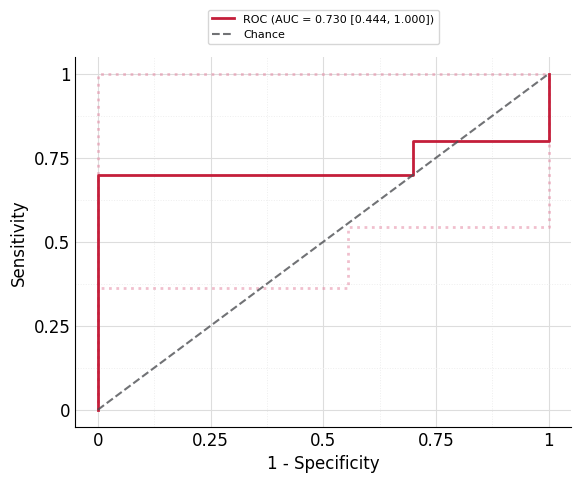

In [76]:
plot_roc(Y, generalized_models_preds['Lasso'])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Recall', ylabel='Precision'>)

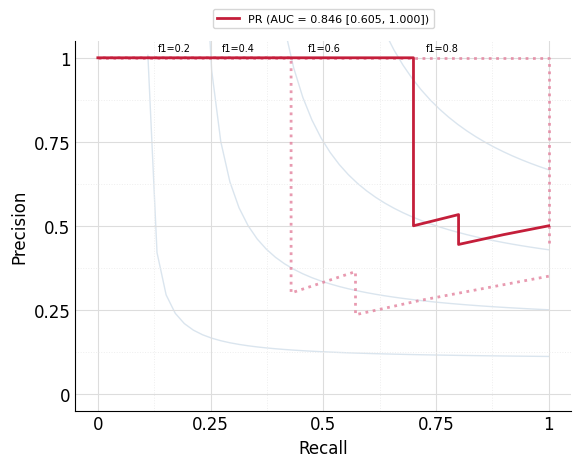

In [77]:
plot_prc(Y, generalized_models_preds['Lasso'])

In [81]:
save_path = Path('./Results', 'SG Time&Model ', time)
os.makedirs(save_path, exist_ok = True)
save_plots(generalized_models_preds, Y, task_type='binary', save_path=save_path)

/Users/jonasamar/Stabl/.venv/lib/python3.9/site-packages/stabl/visualization.py:421: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=ax, y=classes[y_true], x=y_preds, orient='h', palette=palette, **kwargs)
/Users/jonasamar/Stabl/.venv/lib/python3.9/site-packages/stabl/visualization.py:421: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=ax, y=classes[y_true], x=y_preds, orient='h', palette=palette, **kwargs)
/Users/jonasamar/Stabl/.venv/lib/python3.9/site-packages/stabl/visualization.py:421: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=ax, y=classes[y_true], x=y_preds, orient='h', palette=palette, **kwargs)
/Users/jonasamar/Stabl/.venv/lib/python3.9/site-packages/stabl/visualization.py:421: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=ax, y=classes[y_true], x=y_preds, orient='h', palette=palette, **kwargs)
/Use

In [89]:
import csv

generalized_models_weights['Lasso'].sort_values('Associated weight', ascending=False).to_csv(Path(save_path, 'Lasso', 'weights.csv'))